In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from itertools import product

In [2]:
# Euler integration timescale
tmax = 2000 # ms
dt = 1
steps = int(tmax/dt)
ts = np.arange(steps)

width = np.pi / 3
space = 3
n = 23
dsi = space / n
s_centers = np.arange(-space / 2, space / 2, dsi)
s_centers.shape

(23,)

In [3]:
@jit
def tuning(s, width):
    x = np.full(n, s)
    zeros = np.argwhere(np.logical_or(x < s_centers - width / 2, x > s_centers + width / 2))
    x = (np.cos(2 * np.pi * (x - s_centers) / width) + 1) / 8
    x[zeros] = 0
    return x

In [4]:
@jit
def tuning_single(x, width, i):
    s_center = s_centers[i]
    if x < s_center - width / 2 or x > s_center + width / 2: 
        return 0
    else:
        return (np.cos(2 * np.pi * (x - s_center) / width) + 1) / 8

In [5]:
def sim(yhat, a, l, sig, g, cues):
    y1 = np.zeros([n, 2], dtype='float64')
    y2 = np.zeros(n, dtype='float64')
    
    y1 = np.random.random([n, 2]) / 10
    y2 = np.random.random(n) / 10
    
    # synaptic weights
    w = np.flip(np.sqrt(sig / (2 * sig.sum())))
    
    for t in ts[1:]:
        for i in range(2):
            y1[:, i] = cues[i] + np.random.normal(g[i] * cues[i], sig[i])
            
        v2 = y1 @ w # weighted sum of the input to layer 2
        # layer 2
        f = y2 - v2
        ghat = y2.sum()
        p = y2 / ghat**2 - yhat / ghat - np.sum(y2**2 / ghat**3 + yhat * y2 / ghat**2) # prior
        y2 += dt / tau * (-a * l * f - a * (1 - l) * p)
            
        # clip responses
        y2[np.argwhere(y2 < 0)] = 0
    return y2

Text(0.5, 1.0, 'Tuning curves (n = 23)')

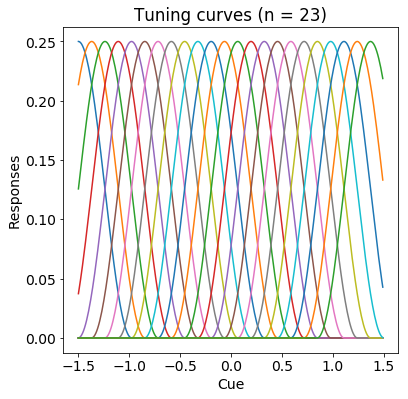

In [15]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1)
fig.set_size_inches(6, 6)
for i in range(23):
    s = np.arange(-1.5, 1.5, 0.01)
    x = np.zeros(s.shape)
    for (j,), cue in np.ndenumerate(s):
        x[j] = tuning_single(cue, width, i)
    ax.plot(s, x)
ax.set_xlabel('Cue')
ax.set_ylabel('Responses')
ax.set_title('Tuning curves (n = {})'.format(n))

In [7]:
ss = np.arange(-1, 1, 0.1)
yhat = tuning(0, width)
cues = [tuning(0.1, width), tuning(0.2, width)]
sig = np.array([4., 1.])
tau = 1

In [8]:
@jit
def readout(y2, psi):
    ghat = y2.sum()
    return np.exp(- a * (l * ghat**2 + 1 - l) / 2 * np.sum((y2 / ghat - psi)**2))

In [9]:
def estimate(g):
    h = np.zeros(ss.shape)
    y2 = sim(yhat, a, l, sig, g, cues)
    
    for i, si in enumerate(ss):
        psi = tuning(si, width)
        h[i] = readout(y2, psi)
    sumh = h.sum()
    estimate = ss @ h / sumh
    uncertainty = np.sqrt((ss - estimate)**2 @ h / sumh)
    return estimate, uncertainty

In [16]:
def show_response(est, unc, pad=1.1):
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)
    fig.tight_layout(pad=pad)
    im = ax[0].imshow(est, cmap='viridis')
    ax[0].set_title('Estimate')
    fig.colorbar(im, ax=ax[0], shrink=0.7)

    im = ax[1].imshow(unc, cmap='plasma')
    ax[1].set_title('Uncertainty')
    fig.colorbar(im, ax=ax[1], shrink=0.7)

    for i in (0, 1):
        ax[i].set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
        ax[i].set_xticklabels(['0.5', '1', '2', '4', '8', '16', '32', '64'])
        ax[i].set_yticklabels(['', '0.5', '1', '2', '4', '8', '16', '32', '64'])
        ax[i].set_xlabel('cue 2 strength')
        ax[i].set_ylabel('cue 1 strength')
        ax[i].invert_yaxis()

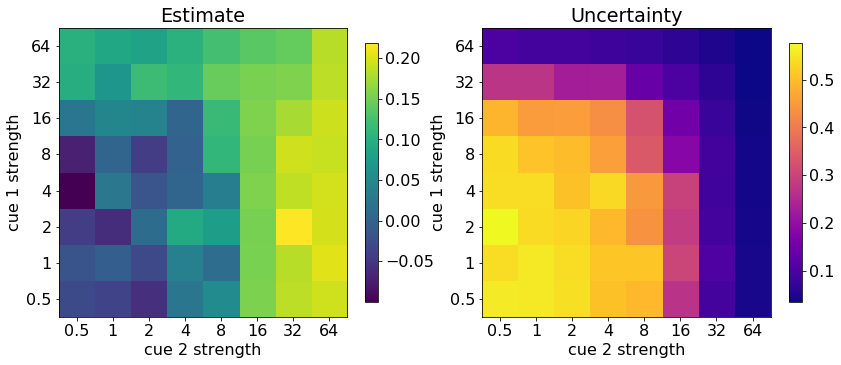

In [11]:
a = 1
l = 0.1
est = np.zeros([8, 8])
unc = np.zeros([8, 8])
for i, j in product(range(8), repeat = 2):
    est[i, j], unc[i, j] = estimate((0.5 * 2**i, 0.5 * 2**j))
show_response(est, unc)

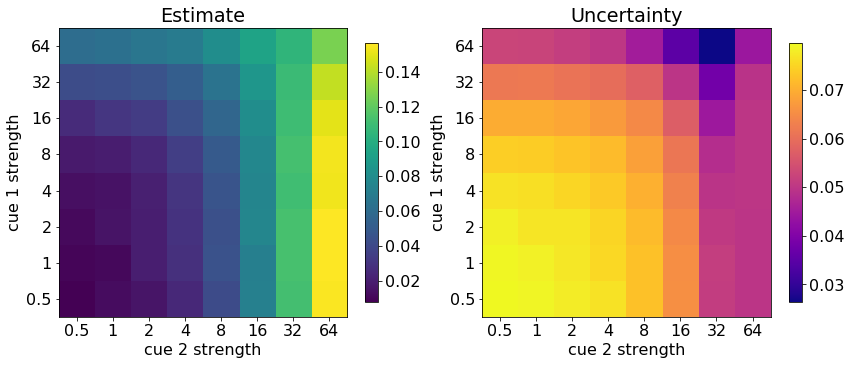

In [12]:
a = 1
l = 0.001
est = np.zeros([8, 8])
unc = np.zeros([8, 8])
for i, j in product(range(8), repeat = 2):
    est[i, j], unc[i, j] = estimate((0.5 * 2**i, 0.5 * 2**j))
show_response(est, unc)

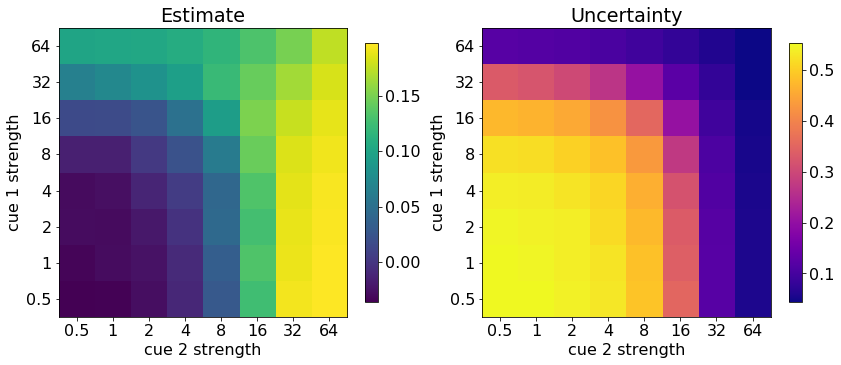

In [13]:
a = 0.01
l = 0.1
est = np.zeros([8, 8])
unc = np.zeros([8, 8])
for i, j in product(range(8), repeat = 2):
    est[i, j], unc[i, j] = estimate((0.5 * 2**i, 0.5 * 2**j))
show_response(est, unc)

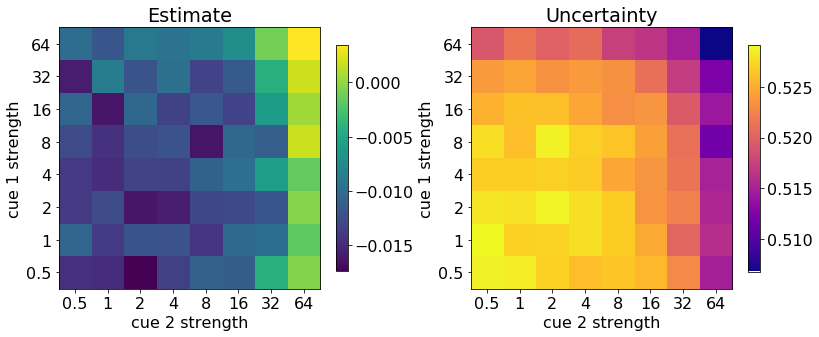

In [20]:
a = 0.01
l = 0.001
est = np.zeros([8, 8])
unc = np.zeros([8, 8])
for i, j in product(range(8), repeat = 2):
    est[i, j], unc[i, j] = estimate((0.5 * 2**i, 0.5 * 2**j))
show_response(est + 0.025, unc, 2.5)